In [1]:
from openadmet.toolkit.chemoinformatics.data_curation import CSVProcessing
import os
import pandas as pd
import numpy as np
from typing import Optional
from collections import defaultdict
import re

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Curating PXR compound activity data from the Tox21 Study for model training
There are a couple of PXR datasets to start with:  
1. 'AID_1347033_datatable.csv' is the summary data from https://pubchem.ncbi.nlm.nih.gov/bioassay/1347033#section=BioAssay-Type  
2. 'AID_1346982_datatable.csv' is the assay data with replicates from https://pubchem.ncbi.nlm.nih.gov/bioassay/1346982  
3. 'AID_1346977_datatable.csv' is the counter screen assay data with replicates from https://pubchem.ncbi.nlm.nih.gov/bioassay/1346977  

Use the function `process_data` to process the raw data files, i.e. add 'CANONICAL_SMILES' and 'INCHIKEY'.

In [2]:
def process_data(input_files:list, input_path:str, output_path:str, force_process:bool=False):
    '''
    Function to process csv data tables from PubChem by adding CANONICAL_SMILES and INCHIKEY with the CSVProcessing class and outputting the resulting csv file to the "processed" folder.

    You can force reprocess all csv data tables in the "input_data" folder by setting force_process=True
    OR you can process only the csv data tables that have not already been processed, aka have a corresponding csv in the "processed" folder.
    '''
    if force_process:
        for i in input_files:
            df = CSVProcessing.read_csv(os.path.join(input_path, i))
            processor = CSVProcessing()
            data = processor.standardize_smiles_and_convert(data=df)
            data.to_csv(os.path.join(output_path, f"processed_{i[:-4]}.csv"), index=False)
    
    else: # process only input files that have not already been processed
        processed_files = os.listdir(output_path)

        for i in input_files:
            if not any(i in f for f in processed_files):
                df = CSVProcessing.read_csv(os.path.join(input_path, i))
                processor = CSVProcessing()
                data = processor.standardize_smiles_and_convert(data=df)
                data.to_csv(os.path.join(output_path, f"processed_{i[:-4]}.csv"), index=False)


In [3]:
root = os.getcwd()
input_folder = 'input_data'
output_folder = 'processed'
input_path = os.path.join(root, input_folder)
output_path = os.path.join(root, output_folder)

input_files = [file for file in os.listdir(input_path) if '.csv' in file]

process_data(input_files=input_files, input_path=input_path, output_path=output_path)

## Now ingest the processed data files for cleaning
If `/processed` folder includes files from multiple proteins, will need to add some logic to get only the data files for, e.g. PXR

In [4]:
protein = "PXR"

processed_files = os.listdir(output_path)
processed_files

['processed_AID_1346982_datatable.csv',
 'processed_AID_1347033_datatable.csv',
 'processed_AID_1346977_datatable.csv']

In [5]:
data = {}

for i in processed_files:
    df = CSVProcessing.read_csv(os.path.join(output_folder, i))
    data[i] = df

data.keys()

/Users/cynthiaxu/Documents/Coding Projects/OMSF/openadmet-toolkit/openadmet/toolkit/chemoinformatics/data_curation.py:21: DtypeWarning: Columns (129,134,141,169,174,181,209,214,221,249,254,261,289,294,301,329,334,341,369,374,381,409,414,421,449,454,461,489,494,501,529,534,541,569,574,581,609,614,621,649,654,661,689,694,701,729,734,741,769,774,781,809,814,821,849,854,861,889,894,901,929,934,941,969,974,981,1009,1014,1021,1049,1054,1061,1089,1094,1101,1129,1134,1141,1169,1174,1181,1209,1214,1221,1249,1254,1261,1289,1294,1301,1329,1334,1341,1369,1374,1381,1409,1414,1421,1449,1454,1461,1489,1494,1501,1529,1534,1541,1569,1574,1581,1609,1614,1621,1649,1654,1661,1689,1694,1701,1729,1734,1741,1769,1774,1781,1809,1814,1821,1849,1854,1861,1889,1894,1901,1929,1934,1941,1969,1974,1981,2009,2014,2021) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path, sep=sep)
/Users/cynthiaxu/Documents/Coding Projects/OMSF/openadmet-toolkit/openadmet/toolkit/ch

dict_keys(['processed_AID_1346982_datatable.csv', 'processed_AID_1347033_datatable.csv', 'processed_AID_1346977_datatable.csv'])

In [6]:
# Rename the dfs to be more readably distinct
summary_df = data['processed_AID_1347033_datatable.csv']
rep_df = data['processed_AID_1346982_datatable.csv']
counter_rep_df = data['processed_AID_1346977_datatable.csv']

print(f"Number rows in summary data {len(summary_df)}. \n" +
      f"Number rows in replicate data {len(rep_df)}. \n" +
      f"Number rows in counter screen replicate data {len(counter_rep_df)}.")

Number rows in summary data 9478. 
Number rows in replicate data 9478. 
Number rows in counter screen replicate data 9478.


### Clean up the replicate data and merge
1. Get the means and standard deviations for all numeric replicate columns  
2. Calculate pAC50 from potency  
3. Drop columns that have all `NaN`  
4. Select only the newly calculated `mean` and `std` columns AND the `OPENADMET_CANONICAL_SMILES` and `INCHIKEY` columns  
5. Merge the screen replicate and counter screen replicate data

In [7]:
def clean_rep_data(df, type:Optional[str]=None):
    rep_cols = [x for x in df.columns if 'Replicate' in x and np.issubdtype(df[x].dtype, np.number) and 'Activity at' not in x]
    # Remove the activity at X uM columns; these are used data points for fitting the Hill Eqn (i assume)
    grouped_cols = defaultdict(list)

    for col in rep_cols:
        base_name = re.sub(r"-?Replicate_\d+$", "", col)
        grouped_cols[base_name].append(col)

    for base, cols in grouped_cols.items():
        if type:
            mean_col = f"{type}_{base.lower()}_mean"
            std_col = f"{type}_{base.lower()}_std"
        else:
            mean_col = f"{base.lower()}_mean"
            std_col = f"{base.lower()}_std"
        df[mean_col] = df[cols].mean(axis=1)
        df[std_col] = df[cols].std(axis=1)

        # Compute pAC50 only if this is a potency column
        if "potency" in base.lower():
            pac50_mean_col = f"{type}_pAC50_mean" if type else "pAC50_mean"
            pac50_std_col = f"{type}_pAC50_std" if type else "pAC50_std"
            
            df[pac50_mean_col] = -np.log10(df[mean_col] * 10**-6)
            df[pac50_std_col] = -np.log10(df[std_col] * 10**-6)
            
        # Drop mean column if all values are NaN
        if df[mean_col].isna().all():
            df.drop(columns=[mean_col], inplace=True)
        
        # Drop std column if all values are NaN
        if df[std_col].isna().all():
            df.drop(columns=[std_col], inplace=True)

    select_cols = ["OPENADMET_CANONICAL_SMILES", "INCHIKEY"]+[x for x in df.columns if "_mean" in x or "_std" in x]

    clean_df = df[select_cols]
    return clean_df

In [8]:
clean_rep_df = clean_rep_data(df=rep_df)
clean_counter_df = clean_rep_data(df=counter_rep_df, type='counter')

# merge the screen replicates and counter screen replicates
merged_rep = clean_rep_df.merge(clean_counter_df, on=["INCHIKEY"], how="inner")
merged_rep

/Users/cynthiaxu/miniconda3/envs/openadmet/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cynthiaxu/miniconda3/envs/openadmet/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,OPENADMET_CANONICAL_SMILES_x,INCHIKEY,potency_mean,potency_std,pAC50_mean,pAC50_std,efficacy_mean,efficacy_std,activity_score_mean,activity_score_std,fit_logac50_mean,fit_logac50_std,fit_hillslope_mean,fit_hillslope_std,fit_r2_mean,fit_r2_std,fit_infiniteactivity_mean,fit_infiniteactivity_std,fit_zeroactivity_mean,fit_zeroactivity_std,fit_curveclass_mean,fit_curveclass_std,max_response_mean,max_response_std,OPENADMET_CANONICAL_SMILES_y,counter_potency_mean,counter_potency_std,counter_pAC50_mean,counter_pAC50_std,counter_efficacy_mean,counter_efficacy_std,counter_activity_score_mean,counter_activity_score_std,counter_fit_logac50_mean,counter_fit_logac50_std,counter_fit_hillslope_mean,counter_fit_hillslope_std,counter_fit_r2_mean,counter_fit_r2_std,counter_fit_infiniteactivity_mean,counter_fit_infiniteactivity_std,counter_fit_zeroactivity_mean,counter_fit_zeroactivity_std,counter_fit_curveclass_mean,counter_fit_curveclass_std,counter_max_response_mean,counter_max_response_std
0,CN1C(=S)CN=C(C2=CC=CC=C2)C2=CC(Cl)=CC=C21,MWGWTOPCKLQYEU-UHFFFAOYSA-N,27.685233,1.874137e+00,4.557752,5.727199,210.622667,42.047072,2.392157,9.664530,-4.558433,0.028868,2.040700,0.257204,0.986367,0.004646,211.970000,44.487858,1.347233,2.461663,2.100000,0.000000,163.761000,35.156967,CN1C(=S)CN=C(C2=CC=CC=C2)C2=CC(Cl)=CC=C21,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-6.175100,NaN,4.954900,NaN,0.608500,NaN,2.166667,3.752777,-1.174833,2.034871,4.000000,0.000000,2.485900,4.947748
1,COC(=O)[C@H]1[C@H]2C[C@@H]3C4=C(CCN3C[C@H]2C[C...,KFDDPVMIQMFHBI-JLIPXIIDSA-N,19.968200,9.383307e+00,4.699661,5.027644,36.472850,4.127312,1.000000,5.882176,-4.791767,0.189297,2.354067,1.011959,0.867533,0.084584,28.038300,9.569687,-1.276933,4.398868,2.533333,1.404754,25.927433,8.569856,COC(=O)[C@H]1[C@H]2C[C@@H]3C4=C(CCN3C[C@H]2C[C...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.875100,NaN,0.300000,NaN,0.347700,NaN,8.666667,15.011107,2.666667,4.618802,4.000000,0.000000,8.523467,8.782994
2,C[C@]12CC3=NON=C3C[C@@H]1CC[C@@H]1[C@@H]2CC[C@...,RGLLOUBXMOGLDQ-IVEVATEUSA-N,27.802900,3.544469e+00,4.555910,5.450449,141.369733,66.251812,2.372549,9.585324,-4.558433,0.057735,3.751800,0.594440,0.940933,0.078723,136.992800,77.035255,-4.376633,10.797480,2.100000,0.000000,118.253267,66.736606,C[C@]12CC3=NON=C3C[C@@H]1CC[C@@H]1[C@@H]2CC[C@...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.475100,0.050000,4.651600,0.525331,0.819267,0.157039,-26.114567,1.299677,-1.333333,0.763763,4.000000,0.000000,-22.039900,1.476921
3,C/C(=C(\CCO)SS/C(CCO)=C(\C)N(C=O)CC1=CN=C(C)N=...,GFEGEDUIIYDMOX-KBNZVFGVSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-5.275100,0.070711,2.173400,0.773292,0.794950,0.040093,11.833333,10.912531,-0.274967,0.443417,4.000000,0.000000,7.065233,13.034656,C/C(=C(\CCO)SS/C(CCO)=C(\C)N(C=O)CC1=CN=C(C)N=...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-5.675100,1.414214,3.837550,1.580172,0.624450,0.251942,5.000000,6.244998,-1.173533,1.385051,4.000000,0.000000,4.920533,4.775286
4,CC1=CC(C)=C(NC(=O)CN(CC(=O)O)CC(=O)O)C(C)=C1Br,MHPZZZZLAQGTHT-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,-0.532867,10.127604,CC1=CC(C)=C(NC(=O)CN(CC(=O)O)CC(=O)O)C(C)=C1Br,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.775100,NaN,1.000000,NaN,0.792100,NaN,3.000000,5.196152,-0.667367,1.155913,4.000000,0.000000,2.233100,3.602799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15899,C[As+](C)(C)CC(=O)[O-],SPTHHTGLGVZZRH-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,5.543000,7.262066,C[As+](C)(C)CC(=O)[O-],NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,-4.177467,3.000546
15900,CCC1=CC=CC(CC)=C1N(COC)C(=O)CS(=O)(=O)O,UTCJUUGCHWHUNI-UHFFFAOYSA-N,3

In [9]:
print(clean_rep_df["INCHIKEY"].duplicated().sum())      # Duplicates in clean_rep_df
print(clean_counter_df["INCHIKEY"].duplicated().sum())  # Duplicates in clean_counter_df


2282
2282


In [10]:
duplicates_counter = clean_counter_df[clean_counter_df["INCHIKEY"].duplicated(keep=False)]
duplicates_counter

,OPENADMET_CANONICAL_SMILES,INCHIKEY,counter_potency_mean,counter_potency_std,counter_pAC50_mean,counter_pAC50_std,counter_efficacy_mean,counter_efficacy_std,counter_activity_score_mean,counter_activity_score_std,counter_fit_logac50_mean,counter_fit_logac50_std,counter_fit_hillslope_mean,counter_fit_hillslope_std,counter_fit_r2_mean,counter_fit_r2_std,counter_fit_infiniteactivity_mean,counter_fit_infiniteactivity_std,counter_fit_zeroactivity_mean,counter_fit_zeroactivity_std,counter_fit_curveclass_mean,counter_fit_curveclass_std,counter_max_response_mean,counter_max_response_std
6,CCCCOC(=O)CC(CC(=O)OCCCC)(OC(C)=O)C(=O)OCCCC,QZCLKYGREBVARF-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.700100,0.247487,3.803350,0.412455,0.708600,0.073963,5.500000,5.766281,-1.532667,1.744549,4.000000,0.000000,4.550900,4.530947
7,O=C(O)C1=CC=CC=C1O,YGSDEFSMJLZEOE-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.775100,NaN,2.333200,NaN,0.621100,NaN,4.833333,8.371579,-0.319100,0.552697,4.000000,0.000000,7.086133,5.204806
49,COC1=CC=C2C[C@@H]3[C@@H]4C=C[C@H](O)[C@@H]5OC1...,OROGSEYTTFOCAN-DNJOTXNNSA-N,58.460367,9.959650,4.233138,5.001756,70.363333,14.318345,2.019608,8.479364,-4.237567,0.076376,2.334333,1.179826,0.887667,0.099871,-72.031400,12.801513,-1.668067,2.852617,-2.166667,0.057735,-55.074300,9.663128
59,CCC(=O)C(CC(C)N(C)C)(C1=CC=CC=C1)C1=CC=CC=C1,USSIQXCVUWKGNF-UHFFFAOYSA-N,22.431367,6.249794,4.649144,5.204134,62.007267,13.965743,1.980392,8.295758,-4.661800,0.132288,1.663167,0.571712,0.945533,0.036446,-63.152933,12.779580,-1.145700,1.189339,-1.833333,0.550757,-58.884233,12.157213
65,O=C(O)C1=CC(OC2=CC=C(C(F)(F)F)C=C2Cl)=CC=C1[N+...,NUFNQYOELLVIPL-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-6.875100,3.181981,4.472450,0.682287,0.357700,0.057417,2.500000,4.330127,-3.858133,6.103566,4.000000,0.000000,3.951067,2.417157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9354,CC(=O)CC(C)=O,YRKCREAYFQTBPV-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-5.363700,NaN,4.954900,NaN,0.371100,NaN,1.333333,2.309401,-0.606933,1.051239,4.000000,0.000000,-1.144300,3.648064
9357,NC1=CC=C(S(=O)(=O)NC2=NC=CS2)C=C1,JNMRHUJNCSQMMB-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,2.096000,1.450386
9367,CN(C)C1=CC=C(C(=C2C=CC(=[N+](C)C)C=C2)C2=CC=CC...,VFCNQNZNPKRXIT-UHFFFAOYSA-N,2.413100,0.551955,5.617425,6.258096,95.402867,4.503197,5.019608,20.278550,-5.625100,0.100000,1.321367,0.065484,0.984067,0.008565,-94.485233,3.463355,0.917533,1.039784,-1.100000,0.000000,-98.828267,1.238268
9373,CC(=O)CC(C)=O,YRKCREAYFQTBPV-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.158300,0.488018


In [11]:
dupes = clean_rep_df["INCHIKEY"][clean_rep_df["INCHIKEY"].duplicated(keep=False)]

# View all rows for those duplicate INCHIKEYs
clean_rep_df[clean_rep_df["INCHIKEY"].isin(dupes)]

,OPENADMET_CANONICAL_SMILES,INCHIKEY,potency_mean,potency_std,pAC50_mean,pAC50_std,efficacy_mean,efficacy_std,activity_score_mean,activity_score_std,fit_logac50_mean,fit_logac50_std,fit_hillslope_mean,fit_hillslope_std,fit_r2_mean,fit_r2_std,fit_infiniteactivity_mean,fit_infiniteactivity_std,fit_zeroactivity_mean,fit_zeroactivity_std,fit_curveclass_mean,fit_curveclass_std,max_response_mean,max_response_std
6,CCCCOC(=O)CC(CC(=O)OCCCC)(OC(C)=O)C(=O)OCCCC,QZCLKYGREBVARF-UHFFFAOYSA-N,7.359100,1.837698,5.133175,5.735726,107.570533,21.203773,4.901961,19.803288,-5.141767,0.104083,3.248033,1.180335,0.982133,0.012398,108.107967,20.778708,0.537367,0.478387,1.100000,0.000000,105.051400,16.471156
7,O=C(O)C1=CC=CC=C1O,YGSDEFSMJLZEOE-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,-5.171733,5.710310
49,COC1=CC=C2C[C@@H]3[C@@H]4C=C[C@H](O)[C@@H]5OC1...,OROGSEYTTFOCAN-DNJOTXNNSA-N,40.793200,9.864847,4.389412,5.005910,59.897150,6.079633,1.588235,7.940218,-5.520900,1.950000,1.371100,0.927850,0.761733,0.350085,38.968700,35.862939,-7.062933,11.710463,2.800000,1.039230,28.122733,42.191081
59,CCC(=O)C(CC(C)N(C)C)(C1=CC=CC=C1)C1=CC=CC=C1,USSIQXCVUWKGNF-UHFFFAOYSA-N,22.291067,11.911613,4.651869,4.924029,53.308200,9.166545,1.980392,8.343837,-4.711800,0.304138,1.887667,0.721032,0.919333,0.053342,56.631600,11.367696,3.323433,2.202446,1.833333,0.550757,32.876600,34.408742
65,O=C(O)C1=CC(OC2=CC=C(C(F)(F)F)C=C2Cl)=CC=C1[N+...,NUFNQYOELLVIPL-UHFFFAOYSA-N,33.491500,NaN,4.475065,NaN,52.170100,NaN,0.196078,1.400280,-4.608433,0.368556,3.569933,2.398833,0.529500,0.000700,28.896467,21.481972,-2.191433,6.302775,3.666667,0.577350,26.224900,16.752211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9354,CC(=O)CC(C)=O,YRKCREAYFQTBPV-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-5.363700,NaN,4.954900,NaN,0.484900,NaN,1.000000,1.732051,-0.917367,1.588926,4.000000,0.000000,-0.095667,2.679789
9357,NC1=CC=C(S(=O)(=O)NC2=NC=CS2)C=C1,JNMRHUJNCSQMMB-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-4.188700,0.035355,2.774750,2.368454,0.702500,0.012587,15.000000,15.000000,0.694267,1.078705,4.000000,0.000000,13.477467,8.420801
9367,CN(C)C1=CC=C(C(=C2C=CC(=[N+](C)C)C=C2)C2=CC=CC...,VFCNQNZNPKRXIT-UHFFFAOYSA-N,1.544933,0.497445,5.811090,6.303255,76.462233,16.755714,4.607843,18.779860,-5.825100,0.132288,4.347267,1.052452,0.992700,0.002685,77.348700,18.390382,0.886433,4.573509,1.133333,0.057735,-21.401933,4.308965
9373,CC(=O)CC(C)=O,YRKCREAYFQTBPV-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-5.163700,0.565685,1.526300,1.027143,0.764450,0.083085,5.333333,4.618802,-0.539767,0.482054,4.000000,0.000000,6.808267,2.794593


In [13]:
rep_df.loc[rep_df['INCHIKEY'] == 'YGSDEFSMJLZEOE-UHFFFAOYSA-N', :]

PUBCHEM_RESULT_TAG  PUBCHEM_SID  PUBCHEM_CID  \
7                      8  144206333.0   54708862.0   
594                  597  144207609.0   16760658.0   
1648                1657  144208669.0        338.0   
6232                6414  144213426.0        338.0   

                          PUBCHEM_EXT_DATASOURCE_SMILES  \
7     C1=CC=C(C(=C1)C(=O)O)[O-].C1=CC=C(C(=C1)C(=O)O...   
594                     C1=CC=C(C(=C1)C(=O)[O-])O.[Na+]   
1648                             C1=CC=C(C(=C1)C(=O)O)O   
6232                             C1=CC=C(C(=C1)C(=O)O)O   

     PUBCHEM_ACTIVITY_OUTCOME  PUBCHEM_ACTIVITY_SCORE  \
7                    Inactive                     0.0   
594                  Inactive                     0.0   
1648                 Inactive                     0.0   
6232                 Inactive                     0.0   

                                   PUBCHEM_ACTIVITY_URL  \
7     http://assay.nih.gov/htsws/rest/display/tox21-...   
594   http://assay.nih.gov/htsws/rest/display/tox21-...   
1648  http://assay.nih.gov/htsws/rest/display/tox21-...   
6232  http://assay.nih.gov/htsws/rest/display/tox21-...   

      PUBCHEM_ASSAYDATA_COMMENT Phenotype-Replicate_1  Potency-Replicate_1  \
7                           NaN              Inactive                  NaN   
594                         NaN              Inactive                  NaN   
1648                        NaN              Inactive                  NaN   
6232                        NaN              Inactive                  NaN   

      Efficacy-Replicate_1  Analysis Comment-Replicate_1  \
7                      NaN                           NaN   
594                    NaN                           NaN   
1648                   NaN                           NaN   
6232                   NaN                           NaN   

      Activity_Score-Replicate_1 Curve_Description-Replicate_1  \
7                              0                           NaN   
594                            0                           NaN   
1648                           0                           NaN   
6232                           0                           NaN   

      Fit_LogAC50-Replicate_1  Fit_HillSlope-Replicate_1  Fit_R2-Replicate_1  \
7                         NaN                        NaN                 NaN   
594                       NaN                        NaN                 NaN   
1648                      NaN                        NaN                 NaN   
6232                  -4.2137                     3.2975               0.561   

      Fit_InfiniteActivity-Replicate_1  Fit_ZeroActivity-Replicate_1  \
7                                  0.0                         0.000   
594                                0.0                         0.000   
1648                               0.0                         0.000   
6232                              21.5                        -3.025   

      Fit_CurveClass-Replicate_1    Excluded_Points-Replicate_1  \
7                            4.0                            NaN   
594                          4.0                            NaN   
1648                         4.0                            NaN   
6232                         4.0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0   

      Max_Response-Replicate_1  Activity at 0.0000060039 uM-Replicate_1  \
7                     -10.8971                                      NaN   
594                    -5.2912                                      NaN   
1648                    2.7171                                      NaN   
6232                   16.6859                                      NaN   

      Activity at 0.0000137707 uM-Replicate_1  \
7                                         NaN   
594                                       NaN   
1648                                      NaN   
6232                                      NaN   

      Activity at 0.0000545120 uM-Replicate_1  \
7                                         NaN   
594             

In [10]:
len(clean_counter_df)

9478

In [11]:
len(merged_rep['INCHIKEY'].unique())

7196

In [41]:
merged_rep.loc[merged_rep['INCHIKEY'] == 'MWGWTOPCKLQYEU-UHFFFAOYSA-N', :]

,OPENADMET_CANONICAL_SMILES,INCHIKEY,potency_mean,potency_std,pAC50_mean,pAC50_std,efficacy_mean,efficacy_std,activity_score_mean,activity_score_std,...,counter_fit_r2_mean,counter_fit_r2_std,counter_fit_infiniteactivity_mean,counter_fit_infiniteactivity_std,counter_fit_zeroactivity_mean,counter_fit_zeroactivity_std,counter_fit_curveclass_mean,counter_fit_curveclass_std,counter_max_response_mean,counter_max_response_std
0,CN1C(=S)CN=C(C2=CC=CC=C2)C2=CC(Cl)=CC=C21,MWGWTOPCKLQYEU-UHFFFAOYSA-N,27.685233,1.874137,4.557752,5.727199,210.622667,42.047072,2.392157,9.66453,...,0.6085,NaN,2.166667,3.752777,-1.174833,2.034871,4.0,0.0,2.4859,4.947748


### Merge replicate data with summary data

In [18]:
full_df = summary_df.merge(merged_rep, on=["OPENADMET_CANONICAL_SMILES", "INCHIKEY"], how="inner")
full_df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Activity Summary,Agonist Activity,...,counter_fit_r2_mean,counter_fit_r2_std,counter_fit_infiniteactivity_mean,counter_fit_infiniteactivity_std,counter_fit_zeroactivity_mean,counter_fit_zeroactivity_std,counter_fit_curveclass_mean,counter_fit_curveclass_std,counter_max_response_mean,counter_max_response_std
0,1,170465705.0,10219.0,CC[C@H]1CN2CCC3=CC(=C(C=C3[C@@H]2C[C@@H]1C[C@@...,Active,100.0,NaN,NaN,active agonist,active agonist,...,0.944733,0.023060,-66.949100,3.906315,2.064733,3.483725,-1.1,0.0,-83.601733,4.874451
1,1,170465705.0,10219.0,CC[C@H]1CN2CCC3=CC(=C(C=C3[C@@H]2C[C@@H]1C[C@@...,Active,100.0,NaN,NaN,active agonist,active agonist,...,0.938900,0.066387,-58.264967,0.922267,-0.115767,0.351672,-1.2,0.0,-71.675400,7.640810
2,1,170465705.0,10219.0,CC[C@H]1CN2CCC3=CC(=C(C=C3[C@@H]2C[C@@H]1C[C@@...,Active,100.0,NaN,NaN,active agonist,active agonist,...,0.944733,0.023060,-66.949100,3.906315,2.064733,3.483725,-1.1,0.0,-83.601733,4.874451
3,1,170465705.0,10219.0,CC[C@H]1CN2CCC3=CC(=C(C=C3[C@@H]2C[C@@H]1C[C@@...,Active,100.0,NaN,NaN,active agonist,active agonist,...,0.938900,0.066387,-58.264967,0.922267,-0.115767,0.351672,-1.2,0.0,-71.675400,7.640810
4,2,170465704.0,6708701.0,C[C@]12C3CCC([C@]1(C(=O)OC2=O)C)O3,Active,99.0,NaN,NaN,active agonist,active agonist,...,0.987500,0.005478,-73.723100,5.696733,-0.560067,1.852724,-1.1,0.0,-72.293067,8.614175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40097,9663,251919825.0,1127.0,C1CCSC1,Inactive,0.0,NaN,NaN,inactive,inactive,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.0,0.0,-0.668067,4.346251
40098,9664,251919641.0,104856.0,CN(CCCC(C1=CN=CC=C1)O)N=O,Inactive,0.0,NaN,NaN,inactive,inactive,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.0,0.0,2.370500,0.708297
40099,9665,251919683.0,104556.0,C1N(CN(CN1CCO)CCO)CCO,Inactive,0.0,NaN,NaN,inactive,inactive,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.0,0.0,2.525000,1.163946
40100,9666,251919642.0,47289.0,CN(CCCC(=O)C1=CN=CC=C1)N=O,Inactive,0.0,NaN,NaN,inactive,inactive,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,4.0,0.0,0.346333,0.551041


In [39]:
full_df.loc[full_df['PUBCHEM_RESULT_TAG'] == 1, :]

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Activity Summary,Agonist Activity,...,counter_fit_r2_mean,counter_fit_r2_std,counter_fit_infiniteactivity_mean,counter_fit_infiniteactivity_std,counter_fit_zeroactivity_mean,counter_fit_zeroactivity_std,counter_fit_curveclass_mean,counter_fit_curveclass_std,counter_max_response_mean,counter_max_response_std
0,1,170465705.0,10219.0,CC[C@H]1CN2CCC3=CC(=C(C=C3[C@@H]2C[C@@H]1C[C@@...,Active,100.0,NaN,NaN,active agonist,active agonist,...,0.944733,0.023060,-66.949100,3.906315,2.064733,3.483725,-1.1,0.0,-83.601733,4.874451
1,1,170465705.0,10219.0,CC[C@H]1CN2CCC3=CC(=C(C=C3[C@@H]2C[C@@H]1C[C@@...,Active,100.0,NaN,NaN,active agonist,active agonist,...,0.938900,0.066387,-58.264967,0.922267,-0.115767,0.351672,-1.2,0.0,-71.675400,7.640810
2,1,170465705.0,10219.0,CC[C@H]1CN2CCC3=CC(=C(C=C3[C@@H]2C[C@@H]1C[C@@...,Active,100.0,NaN,NaN,active agonist,active agonist,...,0.944733,0.023060,-66.949100,3.906315,2.064733,3.483725,-1.1,0.0,-83.601733,4.874451
3,1,170465705.0,10219.0,CC[C@H]1CN2CCC3=CC(=C(C=C3[C@@H]2C[C@@H]1C[C@@...,Active,100.0,NaN,NaN,active agonist,active agonist,...,0.938900,0.066387,-58.264967,0.922267,-0.115767,0.351672,-1.2,0.0,-71.675400,7.640810


In [40]:
list(summary_df.columns)

['PUBCHEM_RESULT_TAG',
 'PUBCHEM_SID',
 'PUBCHEM_CID',
 'PUBCHEM_EXT_DATASOURCE_SMILES',
 'PUBCHEM_ACTIVITY_OUTCOME',
 'PUBCHEM_ACTIVITY_SCORE',
 'PUBCHEM_ACTIVITY_URL',
 'PUBCHEM_ASSAYDATA_COMMENT',
 'Activity Summary',
 'Agonist Activity',
 'Agonist Potency (uM)',
 'Agonist Efficacy (%)',
 'Viability Activity',
 'Viability Potency (uM)',
 'Viability Efficacy (%)',
 'Sample Source',
 'OPENADMET_CANONICAL_SMILES',
 'INCHIKEY']

<Axes: xlabel='PUBCHEM_ACTIVITY_OUTCOME', ylabel='Count'>

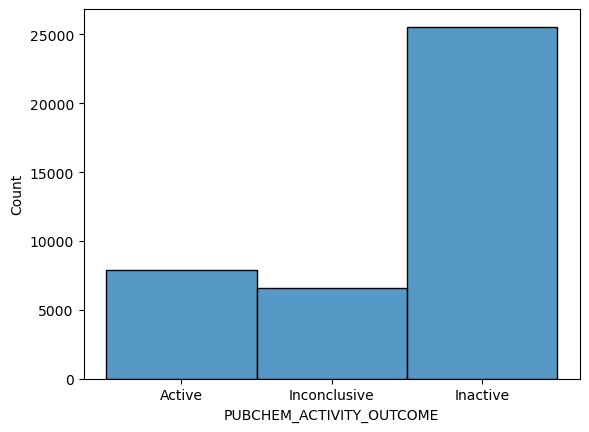

In [19]:
sns.histplot(data=full_df, x='PUBCHEM_ACTIVITY_OUTCOME')

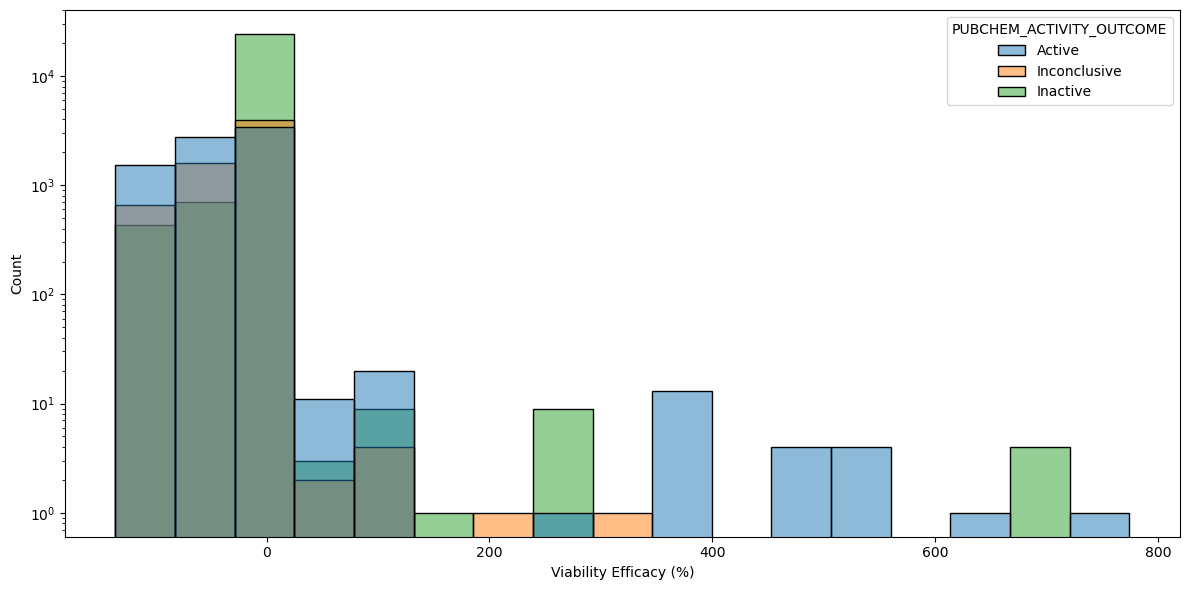

In [32]:
plt.figure(figsize=(12, 6))  # width=12 inches, height=6 inches
sns.histplot(data=full_df, x='Viability Efficacy (%)', hue='PUBCHEM_ACTIVITY_OUTCOME')
plt.yscale('log')
plt.tight_layout()
plt.show()

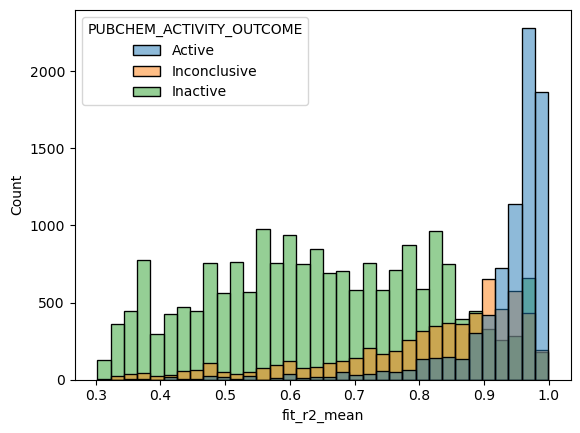

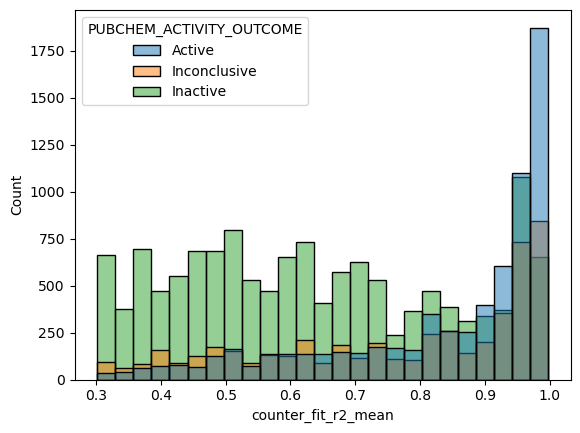

In [29]:
cols = [x for x in full_df.columns if 'r2_mean' in x]
for i in cols:
    sns.histplot(data=full_df, x=i, hue='PUBCHEM_ACTIVITY_OUTCOME')
    plt.show()

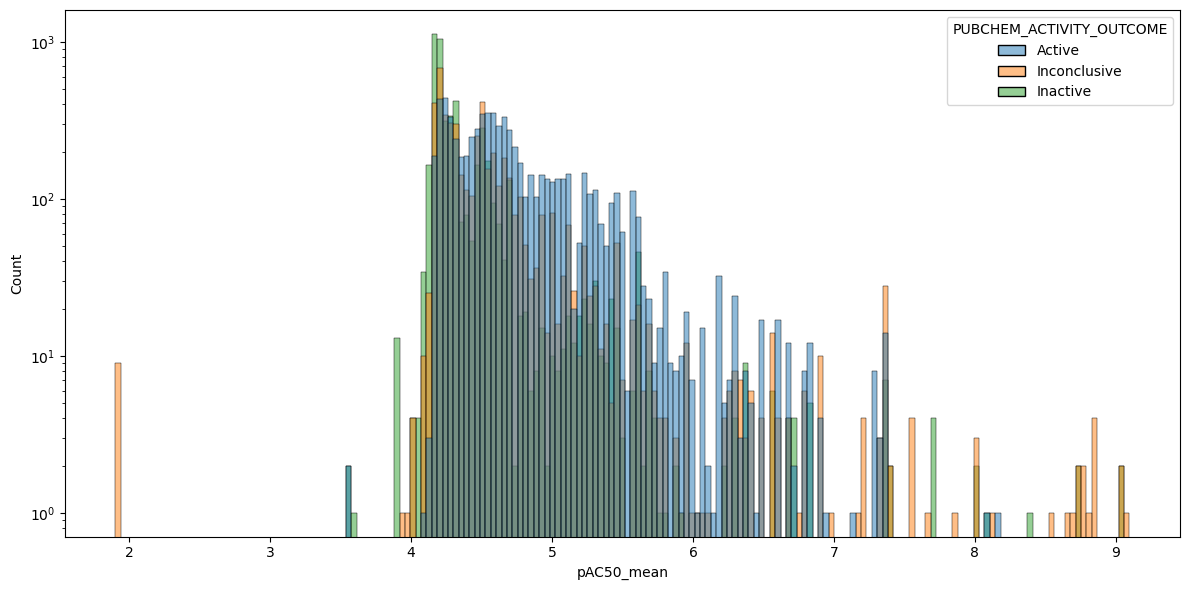

In [35]:
plt.figure(figsize=(12, 6))  # width=12 inches, height=6 inches
sns.histplot(data=full_df, x= 'pAC50_mean', hue='PUBCHEM_ACTIVITY_OUTCOME')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
## this is the revisions
# from pydantic import BaseModel, Field
# from typing import Optional
# from rdkit import Chem

# from openadmet.toolkit.chemoinformatics.rdkit_funcs import canonical_smiles, smiles_to_inchikey

# class CSVProcessing(BaseModel):
#     """
#     Class to handle processing data from a csv downloaded

#     """
#     smiles_col: Optional[str] = None

#     @staticmethod
#     def read_csv(csv_path, sep=","):
#         """
#         Wrapper for inbuilt pandas read_csv()
#         """
#         return pd.read_csv(csv_path, sep=sep)

#     def standardize_smiles_and_convert(self, data):
#         """
#         Converts data to canonical smiles and determines inchikey

#         Parameters
#         ----------
#         data : DataFrame
#             Dataframe of csv of downloaded compound data

#         Returns
#         -------
#         data : DataFrame
#             Dataframe with smiles canonicalized and inchikey
#             column added
#         """

#         if self.smiles_col:
#             if self.smiles_col not in data.columns:
#                 raise ValueError("The provided column is not in the data table!")
#             else:
#                 data["CANONICAL_SMILES"] = data[self.smiles_col].apply(lambda x: canonical_smiles(x))
#                 data["INCHIKEY"] = data["CANONICAL_SMILES"].apply(
#                     lambda x: smiles_to_inchikey(x)
#                 )
#         else:
#             # Get column with SMILES string
#             cols = [col for col in data.columns if 'smiles' in col.lower()]

#             if len(cols) == 1:
#                 col = cols[0]
#                 data["CANONICAL_SMILES"] = data[col].apply(lambda x: canonical_smiles(x))
#                 data["INCHIKEY"] = data["CANONICAL_SMILES"].apply(
#                     lambda x: smiles_to_inchikey(x)
#                 )
                
#             else:
#                 raise ValueError("Multiple columns with SMILES strings detected! Choose one for CANONICAL_SMILES.")

#         data.dropna(subset="INCHIKEY", inplace=True)
#         return data